In [8]:
# 📌 Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, classification_report
from sklearn.cluster import KMeans



In [9]:
# 📌 Step 2: Load dataset
df = pd.read_csv("top_insta_influencers_Cleaned_Data.csv")  # replace with your dataset file name
df.head()


,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes,country
0,1,cristiano,92,3300,475800000,8700000,0.0139,6500000,29000000000,Spain
1,2,kyliejenner,91,6900,366200000,8300000,0.0162,5900000,57400000000,United States
2,3,leomessi,90,890,357300000,6800000,0.0124,4400000,6000000000,Unknown
3,4,selenagomez,93,1800,342700000,6200000,0.0097,3300000,11500000000,United States
4,5,therock,91,6800,334100000,1900000,0.0020,665300,12500000000,United States


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rank               200 non-null    int64  
 1   channel_info       200 non-null    object 
 2   influence_score    200 non-null    int64  
 3   posts              200 non-null    int64  
 4   followers          200 non-null    int64  
 5   avg_likes          200 non-null    int64  
 6   60_day_eng_rate    199 non-null    float64
 7   new_post_avg_like  200 non-null    int64  
 8   total_likes        200 non-null    int64  
 9   country            200 non-null    object 
dtypes: float64(1), int64(7), object(2)
memory usage: 15.8+ KB
None
             rank  influence_score         posts     followers     avg_likes  \
count  200.000000       200.000000    200.000000  2.000000e+02  2.000000e+02   
mean   100.500000        81.820000   3499.850000  7.740950e+07  1.787104e+06   
std     57.

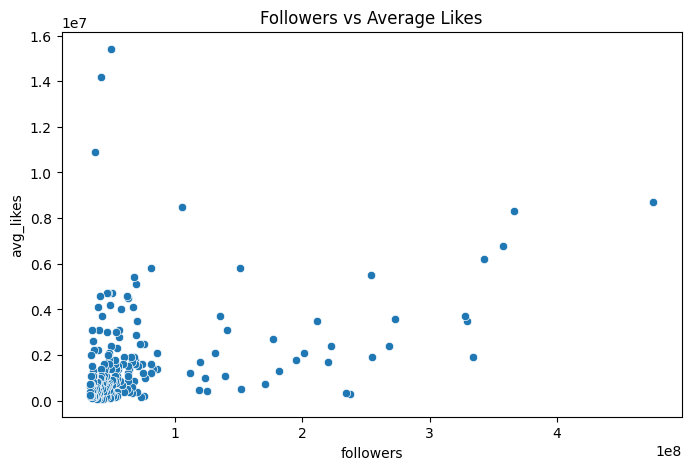

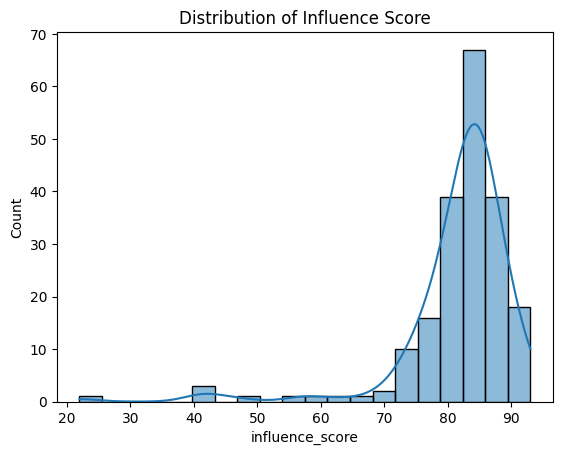

In [10]:
# 📌 Step 3: Data Exploration
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Plot followers vs likes
plt.figure(figsize=(8,5))
sns.scatterplot(x="followers", y="avg_likes", data=df)
plt.title("Followers vs Average Likes")
plt.show()

# Distribution of influence scores
sns.histplot(df["influence_score"], bins=20, kde=True)
plt.title("Distribution of Influence Score")
plt.show()


In [11]:
# 📌 Step 4: Feature Engineering
# Engagement tier (low / mid / high)
q1, q2 = df["60_day_eng_rate"].quantile([0.33,0.66])
def tier(x):
    if pd.isna(x): return np.nan
    if x < q1: return "low"
    elif x < q2: return "mid"
    else: return "high"
df["engagement_tier"] = df["60_day_eng_rate"].apply(tier)

# Like rate = avg likes / followers
df["like_rate"] = df["avg_likes"] / df["followers"]
df.head()



,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes,country,engagement_tier,like_rate
0,1,cristiano,92,3300,475800000,8700000,0.0139,6500000,29000000000,Spain,mid,0.018285
1,2,kyliejenner,91,6900,366200000,8300000,0.0162,5900000,57400000000,United States,high,0.022665
2,3,leomessi,90,890,357300000,6800000,0.0124,4400000,6000000000,Unknown,mid,0.019032
3,4,selenagomez,93,1800,342700000,6200000,0.0097,3300000,11500000000,United States,mid,0.018092
4,5,therock,91,6800,334100000,1900000,0.0020,665300,12500000000,United States,low,0.005687


In [12]:
# 📌 Step 5: Regression - Predict Influence Score
X = df.drop(columns=["influence_score","channel_info","engagement_tier","country"], errors="ignore")
y = df["influence_score"]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
preprocessor = ColumnTransformer([("num", StandardScaler(), num_cols)], remainder="drop")

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
reg = Pipeline([("pre",preprocessor),("model",RandomForestRegressor(n_estimators=200,random_state=42))])
reg.fit(X_train,y_train)
preds = reg.predict(X_test)

print("R²:", r2_score(y_test,preds))
print("MAE:", mean_absolute_error(y_test,preds))
print("RMSE:", mean_squared_error(y_test,preds, squared=False))



R²: -0.06288284395089305
MAE: 6.194625
RMSE: 13.405257853730378


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [13]:
# 📌 Step 6: Classification - Engagement Tier
df_cls = df.dropna(subset=["engagement_tier"])
Xc = df_cls.drop(columns=["influence_score","channel_info","engagement_tier","country"], errors="ignore")
yc = df_cls["engagement_tier"]

num_cols = Xc.select_dtypes(include=[np.number]).columns.tolist()
preprocessor = ColumnTransformer([("num", StandardScaler(), num_cols)], remainder="drop")

Xc_train,Xc_test,yc_train,yc_test = train_test_split(Xc,yc,test_size=0.2, random_state=42)
clf = Pipeline([("pre",preprocessor),("model",RandomForestClassifier(n_estimators=200,random_state=42))])
clf.fit(Xc_train,yc_train)
preds = clf.predict(Xc_test)

print(classification_report(yc_test,preds))


              precision    recall  f1-score   support

        high       1.00      1.00      1.00        17
         low       1.00      0.92      0.96        12
         mid       0.92      1.00      0.96        11

    accuracy                           0.97        40
   macro avg       0.97      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



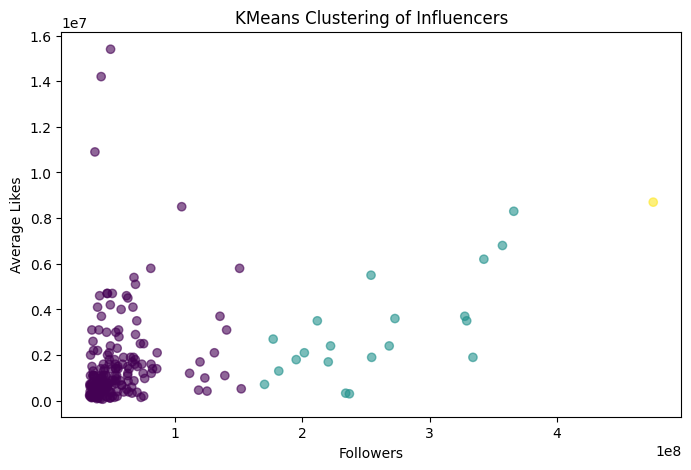

In [14]:
# 📌 Step 7: Clustering - Find Influencer Groups
features = df[["followers","avg_likes"]].dropna()
kmeans = KMeans(n_clusters=3, random_state=42).fit(features)
features["cluster"] = kmeans.labels_

plt.figure(figsize=(8,5))
plt.scatter(features["followers"],features["avg_likes"],c=features["cluster"],cmap="viridis",alpha=0.6)
plt.xlabel("Followers")
plt.ylabel("Average Likes")
plt.title("KMeans Clustering of Influencers")
plt.show()
